In [1]:
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

In [2]:
FOLDER = "first estimation/"

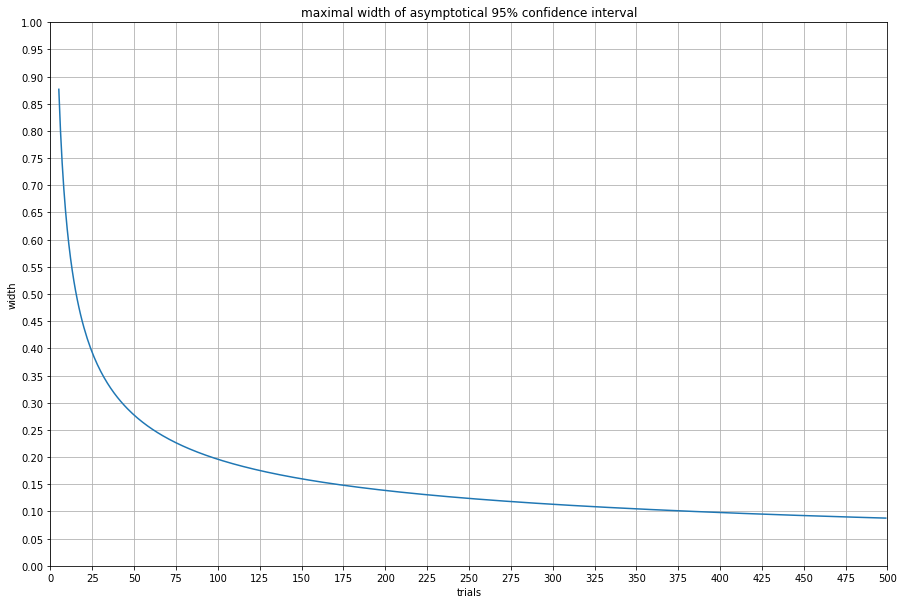

In [3]:
grid = np.arange(5, 500)
y = 1.96 * np.sqrt(1 / grid)
plt.figure(figsize=(15, 10))
plt.plot(grid, y)
plt.xlim(0, 500)
plt.ylim(0, 1)
plt.xticks(np.linspace(0, 500, 21))
plt.yticks(np.linspace(0, 1, 21))
plt.xlabel("trials")
plt.ylabel("width")
plt.title("maximal width of asymptotical 95% confidence interval")
plt.grid()
plt.show()

In [4]:
possible = True
file_number = 0
data = []
for file_number in range(1, 76):
    with open(FOLDER + "results" + str(file_number) + ".pkl", "rb") as fin:
        data.append(pickle.load(fin))

In [5]:
results = {}
for m_samples in [10, 100, 1000]:
    results[m_samples] = {}
    for n_variables in range(2, 5):
        results[m_samples][n_variables] = np.array([0., 0., 0.])
        for i in range(file_number):
            results[m_samples][n_variables] += np.array(
                data[i][m_samples][n_variables])
        results[m_samples][n_variables] /= 75
results = pd.DataFrame(results)

In [6]:
se = {}
for m_samples in [10, 100, 1000]:
    se[m_samples] = {}
    for n_variables in range(2, 5):
        a = np.array(results[m_samples][n_variables])
        se[m_samples][n_variables] = np.sqrt(a * (1 - a) / (file_number * 5))
se = pd.DataFrame(se)

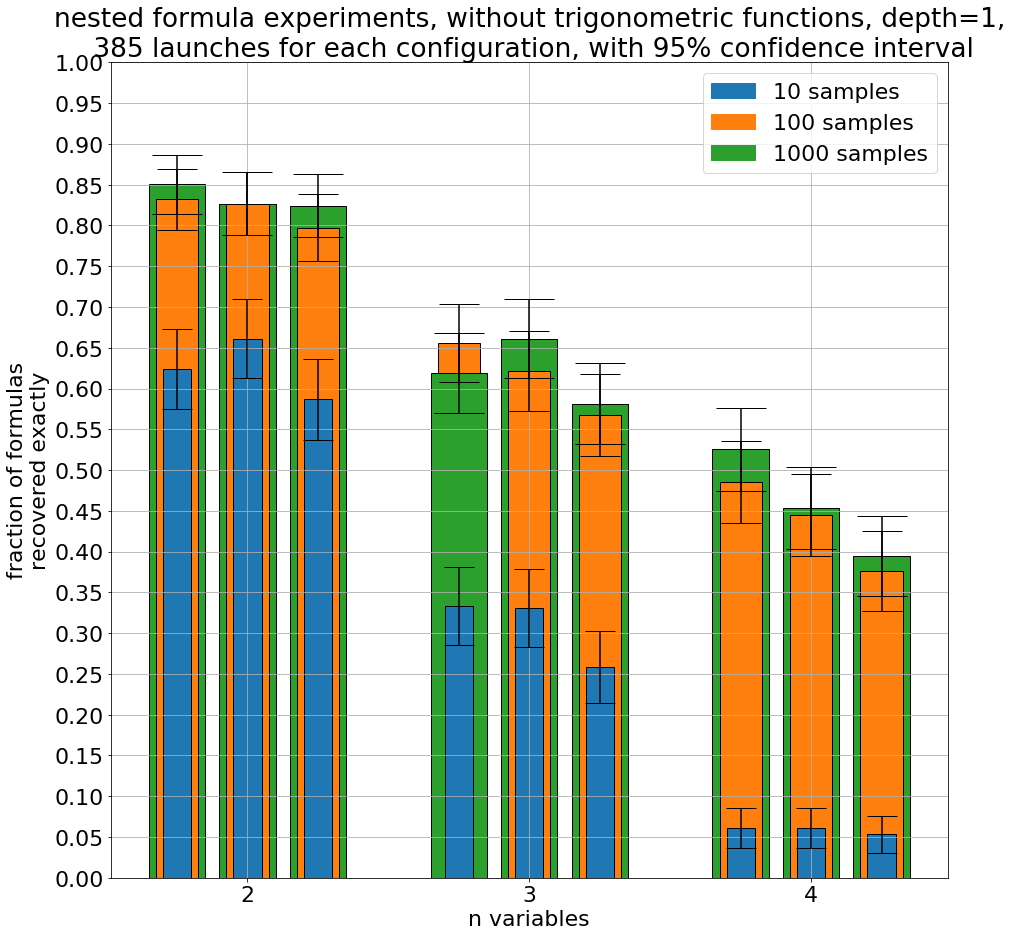

In [10]:
def plot_diagram(alpha=1):
    for powers_type in range(3):
        position = np.arange(2, 5) + (powers_type - 1) / 4

        heights_a, heights_b, heights_c = [
            [results.loc[:, j][i][powers_type] for i in (2, 3, 4)]
            for j in [10, 100, 1000]
        ]

        se_a, se_b, se_c = [
            [se.loc[:, j][i][powers_type] for i in (2, 3, 4)]
            for j in [10, 100, 1000]
        ]

        for x, ha, hb, hc, sea, seb, sec in zip(position, heights_a, heights_b,
                                                heights_c, se_a, se_b, se_c):
            for i, (h, serr, c, ec, width, capsize) in enumerate(
                    sorted(
                        zip([ha, hb, hc], [sea, seb, sec], colors, ecolors,
                            widths, capsizes))):
                if alpha:
                    plt.bar(x,
                            h,
                            color=c,
                            alpha=alpha,
                            zorder=-i,
                            width=width,
                            edgecolor='black')
                else:
                    plt.bar(x,
                            h,
                            yerr=1.96 * serr,
                            color=c,
                            alpha=alpha,
                            capsize=capsize,
                            width=width,
                            edgecolor='black')


barwidth = 0.2
a = np.arange(-1, 2) / 4
colors = ['C0', 'C1', 'C2']
ecolors = ['C3', 'C4', 'C5']
widths = [0.1, 0.15, 0.2]
capsizes = [15, 20, 25]
patches = [
    mpatches.Patch(color=colors[i], label=str(10**(i + 1)) + " samples")
    for i in range(3)
]
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(15, 15))
plt.xlabel('n variables')
plt.ylabel(
    'fraction of formulas\nrecovered exactly',
    #     rotation=0,
    #     labelpad=50
)
plt.xticks([2, 3, 4])
plt.yticks(np.linspace(0, 1, 21))
plt.ylim(0, 1)
plt.grid()
plt.title("nested formula experiments, without trigonometric functions, depth=1,\n {} launches for each configuration, with 95% confidence interval".format(
    385))
plt.legend(handles=patches)
plot_diagram(0)
plot_diagram(1)
plt.savefig(FOLDER + "diagram.jpeg", bbox_inches="tight")
plt.show()

In [12]:
"NestedFormula experiments, {} for each configuration".format(file_number * 5)

'NestedFormula experiments, 375 for each configuration'